In [1]:
# Imports
import os
import sys
import cmath
import math
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import ltspice
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy import signal
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib.ticker import LogLocator

https://training.ti.com/how-design-transimpedance-amplifier-circuits

https://www.tij.co.jp/jp/lit/an/snoa942a/snoa942a.pdf?ts=1622056332116&ref_url=https%253A%252F%252Fwww.google.com%252F

https://www2.eecs.berkeley.edu/Pubs/TechRpts/2020/EECS-2020-146.pdf

<hr>

**IEEE**

https://people.engr.tamu.edu/spalermo/ecen689_oi/2004_rgc_tia_park_jssc.pdf

<hr>

Review of Modern CMOS Transistor

https://www.mdpi.com/2079-9292/8/10/1073/pdf

**Hobbs and AoE**

https://electrooptical.net/static/oldsite/talks/GettingPDRight11.pdf

https://x.artofelectronics.net/wp-content/uploads/2019/11/4xp3_TIA.pdf

<hr>

**Cascode frequency response**

- The photodiode signal current also sees an input impedance of $1/g_{m}$ (at low frequencies) due to the cascode device
- At high frequencies, the diode capacitance $C_d$ shunts the signal current, reducing the current going into the TIA
- The transfer function seen by the photodiode current is
$$
\begin{equation}
i_{in} = \dfrac{1}{1 + sC_d/g_{m}}i_d 
\end{equation}
$$

**Biased cascode noise**

- The bias current of the cascode stage is developed based on the value of $R_E$ and the supply voltage, and is approximately given by $I_{C} = (V_{EE} - 0.6V)/R_E$
 
- For a bias current of, say, $200\mu A$ and a supply voltage of $\pm 15V$, this gives $R_E \approx 72k\Omega$ ($R_C$ will be a similar value)
 
- Still trying to limit the PSD of the thermal noise to $10\%$ of the shot noise limit sets a lower bound on the signal current:
 
\begin{equation}
i_d \geq 10\cdot\dfrac{4kT}{2q\cdot(R_E + R_C)} \approx 3.6\mu A
\end{equation}

 - The output noise contributed by $Q_1$ is minimized by $R_E$, and given by
 
\begin{equation}
i_{nc1,out}^2 = \dfrac{2qI_C}{(1+g_{m1}R_E)^2}
\end{equation}

**Regulated cascode**

- We can achieve both low noise and low input impedance by applying feedback and decreasing $Q_1$'s collector current to reduce both its shot noise and the thermal noise from $R_E$ and $R_{C1}$
 
- The regulated (or, gain-boosted) cascode works by amplifying $Q_1$'s emitter voltage and feeding it back to its base, effectively multiplying the transconductance of $Q_1$ by the voltage gain of the common-emitter amplifer formed by $Q_2$, $R_{C2}$
 
- The input impedance of the regulated cascode is given by
 
\begin{equation}
R_{in} = \dfrac{1}{g_{m1}(1+g_{m2}R_{C2})}
\end{equation}

- The result is an increase in the input pole frequency by the factor $g_{m2}R_{C2}$ *without* a substantial increase in $Q_1$'s collector current (or the resulting base current shot noise)
 
- $Q_1$'s shot noise is reduced even further by the $g_m$-boosting action of the $Q_2$ common-emitter stage, and is given approximately by

\begin{equation}
i_{nc1,out}^2 \approx \dfrac{2qI_{C1}}{(1+g_{m2}R_{C2}g_{m1}R_E)^2}
\end{equation}
 
- $Q_2$'s shot noise sees a gain of
 
\begin{align}
i_{nc2,out} &= \dfrac{g_{m1}R_{C2}}{1+g_{m1}R_E}i_{nc2}\\
\end{align}

<hr>

| Parameter                                             | Specification |
|:------------------------------------------------------|:--------------|
| Transimpedance gain (full signal path)                | $1$ $V/\mu A$ |
| Transimpedance bandwidth ($f_{3dB}$)                  | $1$ $MHz$     |
| Minimum photodiode current ($i_d$)                    | $2$ $\mu A$   |
| Photodiode capacitance ($C_d$)                        | $150$ $pF$    |
| Closed-loop gain magnitude peaking                    | $0$  $dB$     |
| $rms$ noise figure ($F = 1 + i_n^2/i_{ns}^2$)         | $\leq 0.5$ $dB$ |
| Power dissipation ($I_{DD} \cdot (V_{CC} + V_{EE}) $) | Optimize $mW$ |
| Cost-per-unit (1000 units)                            | Optimize $\$$ |

<hr>

**TIA by itself** 

$C_{in}$ is fixed to photodiode (150 pF) + TIA (3-20 pF)

$R_f$ is determined by gain (1e6)

$C_f \approx \sqrt{\dfrac{2\cdot C_{in}}{R_f\omega_t}}$

Since $R_f$ and is $C_{in}$ fixed, $C_f$ is a function of $\omega_t$

$\omega_{3dB} = \sqrt{\frac{\omega_t}{R_f  C_{in}}} = \sqrt{65K \cdot \omega_t}$

And $\omega_{3dB}$ is a function of $\omega_t$. 
<hr>

In [2]:
k = 1.38e-23
T = 300
q = 1.602e-19
V_T = k*T/q

# Photodiode
Cd = 150*1e-12
Id = 2*1e-6

# TIA LF356
A0 = 200*1e3
C_TIA = 3*1e-12
ft = 4*1e6
# Vp = 7
# Vn = -4

# Parameters
Cin = Cd + C_TIA
wt = 2*np.pi*ft
Rf = 100*1e3

The closed-loop transfer function of the TIA is second order, and can be expressed as

$\begin{eqnarray}
&& H(s)  &=& {\frac {\omega _{0}^{2}}{s^{2}+2\zeta \omega _{0}\cdot s+\omega _{0}^{2}}} \\[0.5em]
&&       &=& {\frac {\omega _{0}^{2}}{s^{2}+\frac{s\cdot\omega_0}{Q}+\omega _{0}^{2}}} \\[0.5em]
&&       &=& {\frac {1}{\frac{s^{2}}{\omega_0^2}+\frac{s\cdot\omega_0}{Q}+1}}  \\[0.5em]
&& \frac{V_{out}}{i_{in}} &\approx& -R_f \frac{1}{1 + s R_f C_f + \frac{s^2}{\omega_u}R_f  C_{in}} \\[0.5em]
&& \frac{1}{\omega_0^2} &=& \frac{R_f  C_{in}}{\omega_u} \\[0.5em]
&& \omega_0^2 &=& \frac{\omega_u}{R_f  C_{in}} \\[0.5em]
&& \omega_0 &=& \sqrt{\frac{\omega_u}{R_f  C_{in}}} \\[0.5em]
&& \omega_u &\approx& \omega_t
\end{eqnarray}$

<hr>

$\begin{eqnarray}
& \omega_{3dB_{CL}} & &=& \omega_0 \\[0.5em]
& \omega_{3dB_{CL}}& &=& \sqrt{\frac{\omega_u}{R_f  C_{in}}} \\[0.5em]
&& &=& \sqrt{\frac{\omega_t}{R_f  C_{in}}} \\[0.5em]
\end{eqnarray}$

<hr>

That is, in order to achieve a "well-behaved response" we must set $\omega_z = \sqrt{\omega_{p,cl}\omega_t}$

$$
\begin{eqnarray}
\omega_z &=& \frac{1}{R_fC_f} \\
\omega_t && && \text{ [transit frequency]} \\
\omega_{p,cl} &=& \frac{1}{R_f(C_f+C_{in})} && \text{ [parasitic pole]}\\
\end{eqnarray}
$$

"The transimpedance rolls off somewhat
earlier than this, since it depends on the
magnitudes of the impedances of the feed-
back elements, and not merely on their ratio.
Without getting into lots of algebra, we
lose a factor of between √2 and 2 in band-
width, depending on the details of the 
frequency compensation scheme"

$\begin{eqnarray}
&& f_{-3dB} &=& \frac{\sqrt{f_{RC}f_T}}{2}
\end{eqnarray}$

<hr>

In [3]:
f_RC = 1/(Rf*Cin)
f3db = np.sqrt(f_RC * ft)/2
print(f'Worst case f3db = {round(f3db)} Hz')

Worst case f3db = 255655 Hz


<hr>

For a damping factor of $\zeta = 1/\sqrt{2}$ (or equivalently, $Q=1/\sqrt{2}$, a maximally flat response), and assuming $C_{in}>>C_f$, the required value of $C_f$ is approximately
$$ 
\begin{equation}
C_f \approx \sqrt{\dfrac{2\cdot C_{in}}{R_f\omega_t}} = \dfrac{1}{R_f}\sqrt{\dfrac{2\cdot R_f C_{in}}{\omega_t}}
\end{equation}
$$

In [4]:
Cf = np.sqrt(2*Cin/(Rf*wt))
print(f'Cf = {round(Cf*1e12,3)/(1e12)}')

Cf = 1.1034e-11


<hr>

Assuming an ideal (infinite-bandwidth) opamp, the noise transfer function is the input/output relationship for the amplifier voltage noise
$$
\begin{eqnarray}
\dfrac{e_{na,out}}{e_{na}} &=& \left(1+\dfrac{Z_f}{Z_{in}}\right)\\ 
\\
&=& \dfrac{1+s(C_{in}+C_f)R_f}{1+sC_fR_f}
\end{eqnarray}
$$


 - This expression has a zero at $1/R_f(C_{in}+C_f) \approx 1/R_fC_{in}$, which results in "peaking" of the output noise due to $e_{na}$ and significantly degrades the noise performance of the TIA
 
 - The noise due to $e_{na}$ rises with frequency, as the impedance of $C_{in}$ decreases

0 dB Closed-loop gain magnitude peaking results in 

$\begin{eqnarray}
&& 1+s(C_{in}+C_f)R_f &=& 1+sC_fR_f
\end{eqnarray}$

Such that $C_{in} \geq 100 C_f$

$C_f \leq 1.5$ pF 

<hr>

**Noise Figure**

$$\begin{eqnarray}
&& F = 1 + i_n^2/i_{ns}^2
\end{eqnarray}$$

The photodiode produces a shot noise current with power spectral density given by 
$$
\begin{equation}
i_{ns}^2 = 2qi_d
\end{equation}
$$

$\begin{eqnarray}
&& i_n^2 &=& \left[\frac{\text{op amp noise}}{G}\right]^2 + \left[\frac{\text{thermal noise}(R_f)}{G}\right]^2 \\[0.5em]
&& i_n^2 &=& \left[\frac{e_{na,out}}{G} \right]^2 + \left[ \frac{\sqrt{4 kT R_f}}{G}\right]^2 \\[0.5em]
&& G &=& R_f \\[0.5em]
&& i_n^2 &=& \left[\frac{e_{na,out}}{R_f} \right]^2 + \left[ \frac{\sqrt{4 kT R_f}}{R_f}\right]^2 \\[0.5em]
&& i_n^2 &=& \left[\frac{1}{R_f} \cdot \dfrac{1+s(C_{in}+C_f)R_f}{1+sC_fR_f} e_{na} \right]^2 + \left[ \frac{\sqrt{4 kT R_f}}{R_f}\right]^2 \\[0.5em]
&& i_n^2 &\approx& \left[\dfrac{sC_{in}}{1+sC_fR_f} e_{na} \right]^2 + \left[ \sqrt{\frac{4 kT}{R_f}} \right]^2 \\[0.5em]
\end{eqnarray}$

<hr>

Guide to Regulated Cascode 
https://www.researchgate.net/publication/312288934_A_Design_Methodology_to_Extend_Bandwidth_for_Regulated_Cascode_Transimpedance_Amplifier

Transistor Queries

https://www.onsemi.com/search-results/?bz-search=Low%20low%20noise%20transistors&key=y7kv6g0vp5&bz-page=1&is_redirect=true&bz-results-per-page=10&bz-pc=1

https://www.ti.com/amplifier-circuit/special-function/transconductance/products.html

## Filter design (OPA657)


| Paramete   | Specification |
|:-----------|:--------------|
| Closed-loop gain magnitude peaking  | $0$  $dB$     |
| Transimpedance bandwidth ($f_{3dB}$) | $1$ $MHz$     |


<hr>

Butterworth design for 0 dB peaking such that $2\zeta = \dfrac{1}{Q} = 1/\sqrt{2}$. 

Find resulting $C_f$ and $f_{3dB}$. 

$\begin{eqnarray}
&& \omega_t &=& 2 \pi \text{ (1600 MHz)}  \\[0.5em]
&& C_{in} &=& (150 \text { pF}) + 5.2 \text { pF}) = 155.2 \text { pF} \\[0.5em]
&& C_f &=& \sqrt{\dfrac{2\cdot C_{in}}{R_f\omega_t}} = 0.56 \text { pF} \\[0.5em]
&& \omega_{3dB} = \omega_0 &=& \sqrt{\dfrac{\omega_t}{R_f(C_{in} + C_f)}} \\[0.5em]
&& f_{3dB} &=& \omega_{3dB}/(2\pi) = 4 \text{ MHz} \\[0.5em]
\end{eqnarray}$

## Noise Design (OPA846)

| Parameter                 | Specification |
|:--------------------------|:--------------|
| Minimum photodiode current ($i_d$) | $2$ $\mu A$ |

<hr>

Input Photodiode Current Noise Density

$\begin{eqnarray}
&& i_{ns}^2 &=& 2qi_d \\[0.5em]
&& i_{ns} &=& \sqrt{2qi_d} = 0.8 \text{ pA}/ \sqrt{Hz} \\[0.5em]
\end{eqnarray}$

<hr>

Input-Referred Thermal Noise Density

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{\sqrt{4kT R_f}}{R_f} = \sqrt{\frac{4kT}{R_f}} = 0.41 \text{ pA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

<hr>

Input-Referred Op Amp Noise

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{e_n}{R_f} = \frac{1.2 nV}{100K} = 12 \text{ fA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

## Noise Density (OPA846)

| Parameter  | Specification |
|:-----------|:--------------|
| $i_{n,out}$ | 0.28 pV /$\sqrt{\text{Hz}}$ |

<hr>

Input-Referred Current Noise Density 
- Exclude shot noise
- Exclude TIA Transfer Function

$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_{na}}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& i_{n,in} &=& \sqrt{{(2.8 pA)}^2 + \frac{4kT}{100K} + \left(\frac{1.2 nV}{100K}\right)^2} \\[0.5em]
&&  i_{n,in} &=&  2.83 \text{ pA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

Note, the input referred is 10x larger than the threshold! 

## Noise Density (OPA657)

| Parameter  | Specification |
|:-----------|:--------------|
| $rms$ noise figure | $\leq 0.5$ $dB$ |
| $i_{n,out}$ | 0.28 pA /$\sqrt{\text{Hz}}$ |

<hr>

Input-Referred Current Noise Density 
- Exclude shot noise
- Exclude TIA Transfer Function

$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_{na}}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& i_{n,in} &=& \sqrt{{(1.3 fA)}^2 + \frac{4kT}{100K} + \left(\frac{4.8 nV}{100K}\right)^2} \\[0.5em]
&&  i_{n,in} &=&  0.41 \text{ pA}/\sqrt{\text{Hz}} \\[0.5em]
\end{eqnarray}$

## Continued: Find Voltage Noise Threshold

Input-Referred Thermal Noise Density:

$\begin{eqnarray}
&&  i_{n,R_f} &=& \frac{\sqrt{4kT R_f}}{R_f} = \sqrt{\frac{4kT}{R_f}} = 0.41 \text{ pA} \\[0.5em]
\end{eqnarray}$

<hr>

Current Noise Density excluding shot:

$\begin{eqnarray}
&& i_{n,in} &=& \sqrt{{i_n}^2 + \frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& i_{n,in}^2 &\approx& \sqrt{\frac{4kT}{R_f} + \left(\frac{e_n}{R_f}\right)^2} \\[0.5em]
&& \left(\frac{e_n}{R_f}\right)^2  &=& i_{n,in}^2  - \frac{4kT}{R_f} \\[0.5em]
&& e_{n,in}  &=&  R_f \sqrt{i_{n,in}^2   - \frac{4kT}{R_f}} & \text{ not solvable; thermal noise is larger} \\[0.5em]
\end{eqnarray}$

## Filter design (OPA846)


| Paramete   | Specification |
|:-----------|:--------------|
| Closed-loop gain magnitude peaking  | $0$  $dB$     |
| Transimpedance bandwidth ($f_{3dB}$) | $1$ $MHz$     |


<hr>

Butterworth design for 0 dB peaking such that $2\zeta = \dfrac{1}{Q} = 1/\sqrt{2}$. 

Find resulting $C_f$ and $f_{3dB}$. 

$\begin{eqnarray}
&& \omega_t &=& 2 \pi \text{ (1750 MHz)}  \\[0.5em]
&& C_{in} &=& (150 \text { pF}) + (\sim 5 \text { pF}) = 155 \text { pF} \\[0.5em]
&& C_f &=& \sqrt{\dfrac{2\cdot C_{in}}{R_f\omega_t}} = 0.53 \text { pF} \\[0.5em]
&& \omega_{3dB} = \omega_0 &=& \sqrt{\dfrac{\omega_t}{R_f(C_{in} + C_f)}} \\[0.5em]
&& f_{3dB} &=& \omega_{3dB}/(2\pi) = 4.2 \text{ MHz} \\[0.5em]
\end{eqnarray}$

## Continued: Assume Noiseless Rf

Input-Referred Voltage Noise Density:

$\begin{eqnarray}
&& i_{n,in}^2 &\approx& \left[\text{op amp noise}\right]^2 \\[0.5em]
&& \left(\frac{e_n}{R_f}\right)^2  &=& i_{n,in}^2  \\[0.5em]
&& e_{n,in} &=&  i_{n,in} R_f \\[0.5em]
&& &=& \frac{i_{n,out}}{R_f} R_f \\[0.5em]
&& &=& 0.28 \text{ pV}/ \sqrt{Hz} \\[0.5em]
\end{eqnarray}$

Voltage noise density must be less than $\sqrt{0.122} \cdot i_{ns}$

Choose $R_f$ to be such that $R_f = 100 \Omega$ so that achievable performance can be met.

Need additional stages. Best TIA's have performance on the order of $\sim 1 \text{ nV}/ \sqrt{Hz}$.

## AC Response

| Paramete   | Specification |
|:-----------|:--------------|
| Closed-loop gain magnitude peaking  | $0$  $dB$     |
| Transimpedance bandwidth ($f_{3dB}$) | $1$ $MHz$     |

In [5]:
# Plot Input-Referred Current Noise Density
s,e_na,i_na,C_TIA = sp.symbols('s,e_na,i_na,C_TIA')
f = np.logspace(0, 7, 10000)
w = 2*np.pi*f

# OPA657
components1 = {
    e_na : 4.8*1e-9,
    i_na : 1.3*1e-15,
    C_TIA : 5.2*1e-12
}
# OPA846
components2 = {
    e_na : 1.2*1e-9,
    i_na : 2.8*1e-12,
    C_TIA : 3.8*1e-12
}

i_ns = 2*q*Id
GBW = 1600*1e6
wt = 2*sp.pi*GBW
Rf = 100*1e3
Cin = Cd + C_TIA
Cf = sp.sqrt(2*Cin/(2*sp.pi*GBW*Rf))
en = e_na*((Cin+Cf)*Rf*s + 1)/(Cf*Rf*s + 1)
noise_sq = i_na**2 + 4*k*T/Rf + (en/Rf)**2 # + (1/3)*(en*2*sp.pi*fenb*Cin)**2
noise = sp.sqrt(noise_sq)

In [6]:
H = sp.Matrix([noise])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

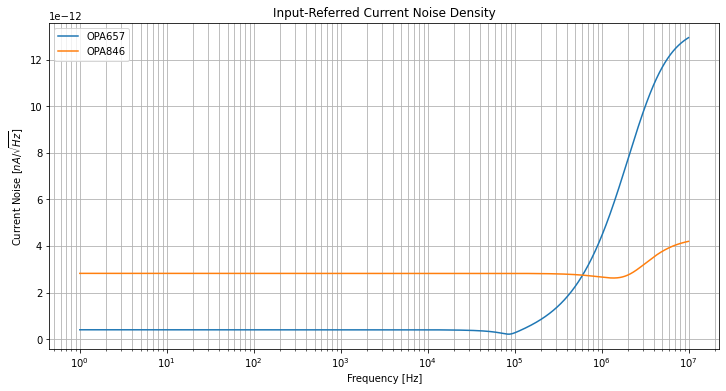

In [7]:
fig, ax = plt.subplots(figsize=(12,6))
ax.set_title('Input-Referred Current Noise Density')
ax.semilogx(f, abs(H1),label=r'OPA657')
ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Current Noise [$nA/\sqrt{Hz}$]')
ax.set_xlabel('Frequency [Hz]')
ax.ticklabel_format(style='sci',axis='y',scilimits=(-12,-12))
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

In [8]:
f = np.logspace(0, 5, 10000)
w = 2*np.pi*f

H = sp.Matrix([10*sp.log(1+noise_sq/i_ns,10)])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

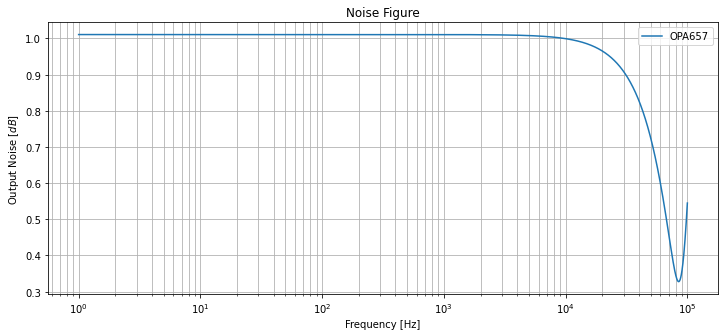

In [9]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Noise Figure')
ax.semilogx(f, abs(H1),label=r'OPA657')
#ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Output Noise [$dB$]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

In [10]:
f3db = sp.sqrt(GBW/(2*sp.pi*Rf*Cin))
# fenb = 1.11*f3dB
w0 = sp.sqrt(wt/(Cin+Cf)/Rf)
zeta = Rf*Cf*w0/2
TIA = (Rf*w0**2)/(s**2 + 2*s*zeta*w0 + w0**2)

In [11]:
H = sp.Matrix([TIA])
H1 = H.subs(components1)
H2 = H.subs(components2)
H1 = lambdify(s,H1,modules='numpy')
H1 = H1(1j*w)
H1 = H1[0][0]
H2 = lambdify(s,H2,modules='numpy')
H2 = H2(1j*w)
H2 = H2[0][0]

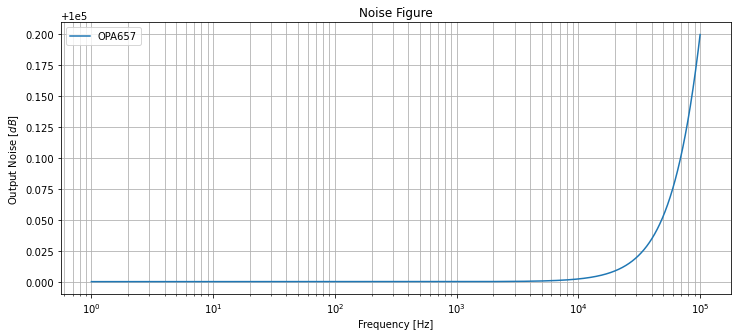

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
ax.set_title('Noise Figure')
ax.semilogx(f, abs(H1),label=r'OPA657')
#ax.semilogx(f, abs(H2),label=r'OPA846')
ax.set_ylabel(r'Output Noise [$dB$]')
ax.set_xlabel('Frequency [Hz]')
ax.grid(which='both', axis='both')
ax.legend()
plt.show();

In [14]:
def f(Rf,GBW,C_TIA,e_n,i_n,Cd,Id):
    x = sp.symbols('x')
    d = {}
    wt = 2*np.pi*GBW
    Cin = C_TIA+Cd
    Cf = np.sqrt(2*Cin/(Rf*wt))
    f_RC = 1/(Rf*Cin)
    f3db = np.sqrt(GBW/(2*np.pi*Rf*Cin))
    i_ns = np.sqrt(2*q*Id)
    thermal_input = np.sqrt(4*k*T/Rf)
    i_input_ref = np.sqrt(0.122)
    e_input_ref = np.sqrt( (i_n**2)*(Rf)**2)
    d['Rf'] = Rf
    d['Cf'] = Cf
    d['f_RC'] = f_RC
    d['f3db']= f3db
    d['i_ns'] = i_ns
    d['thermal_input'] = thermal_input
    d['i_input_ref'] = i_input_ref
    d['e_input_ref'] = e_input_ref
    return d

In [15]:
Rf = 100*1e3
GBW = 1600*1e6
C_TIA = 5.2*1e-12
e_n = 2.2*1e-9
i_n = 3*1e-15

f(Rf,GBW,C_TIA,e_n,i_n,Cd,Id)

{'Rf': 100000.0,
 'Cf': 5.556622981616415e-13,
 'f_RC': 64432.989690721646,
 'f3db': 4050645.1451525567,
 'i_ns': 8.004998438475799e-13,
 'thermal_input': 4.069397989875161e-13,
 'i_input_ref': 0.3492849839314596,
 'e_input_ref': 3e-10}